# Custom Criterion for DecisionTreeRegressor

A [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) can be trained with a couple of possible criterions but it is possible to implement a custom one (see [hellinger_distance_criterion](https://github.com/EvgeniDubov/hellinger-distance-criterion/blob/master/hellinger_distance_criterion.pyx)). See also tutorial [Cython example of exposing C-computed arrays in Python without data copies](http://gael-varoquaux.info/programming/cython-example-of-exposing-c-computed-arrays-in-python-without-data-copies.html) which describes a way to implement fast [cython](https://cython.org/) extensions.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Piecewise data

Let's build a toy problem based on two linear models.

In [3]:
import numpy
import numpy.random as npr
X = npr.normal(size=(1000,4))
alpha = [4, -2]
t = (X[:, 0] + X[:, 3] * 0.5) > 0
switch = numpy.zeros(X.shape[0])
switch[t] = 1
y = alpha[0] * X[:, 0] * t + alpha[1] * X[:, 0] * (1-t) + X[:, 2]

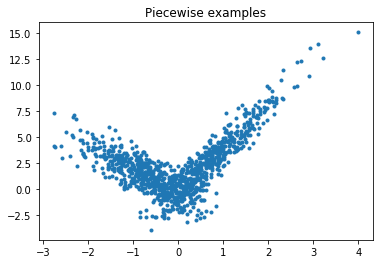

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(X[:, 0], y, ".")
ax.set_title("Piecewise examples");

## DecisionTreeRegressor

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:, :1], y)

In [6]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=100)
model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=100,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [7]:
pred = model.predict(X_test)
pred[:5]

array([ 1.72132112,  2.83116866,  6.6093736 , -0.11486427,  1.72132112])

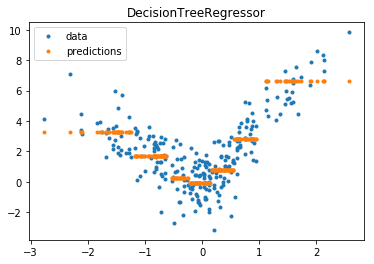

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label='data')
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor")
ax.legend();

## DecisionTreeRegressor with custom criterion

In [9]:
import sklearn
from pyquickhelper.texthelper import compare_module_version
if compare_module_version(sklearn.__version__, '0.21') < 0:
    print("Next step requires scikit-learn >= 0.21")
else:
    print("sklearn.__version__ =", sklearn.__version__)

sklearn.__version__ = 0.21.dev0


In [10]:
from mlinsights.mlmodel.piecewise_tree_regression_criterion import SimpleRegressorCriterion

In [11]:
model2 = DecisionTreeRegressor(min_samples_leaf=100,
                              criterion=SimpleRegressorCriterion(X_train))
model2.fit(X_train, y_train)

DecisionTreeRegressor(criterion=<src.mlinsights.mlmodel.piecewise_tree_regression_criterion.SimpleRegressorCriterion object at 0x0000022C7CDC4B90>,
                      max_depth=None, max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=100, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=None, splitter='best')

In [12]:
pred = model2.predict(X_test)
pred[:5]

array([ 1.07517148,  3.35558756,  6.90848789, -0.05382236,  1.07517148])

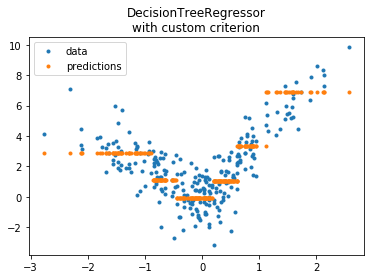

In [13]:
fig, ax = plt.subplots(1, 1)
ax.plot(X_test[:, 0], y_test, ".", label='data')
ax.plot(X_test[:, 0], pred, ".", label="predictions")
ax.set_title("DecisionTreeRegressor\nwith custom criterion")
ax.legend();

## Computation time

The custom criterion is not really efficient but it was meant that way. The code can be found in [piecewise_tree_regression_criterion](https://github.com/sdpython/mlinsights/blob/master/src/mlinsights/mlmodel/piecewise_tree_regression_criterion.pyx). Bascially, it is slow because each time the algorithm optimizing the tree needs the class Criterion to evaluate the impurity reduction for a split, the computation happens on the whole data under the node being split. The implementation in [_criterion.pyx](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_criterion.pyx) does it once.

In [14]:
%timeit model.fit(X_train, y_train)

899 µs ± 62.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%timeit model2.fit(X_train, y_train)

84.3 ms ± 5.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
